In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
regenerate = False

if regenerate:
    import spacy
    import textdescriptives as td
    import textstat
    from pandarallel import pandarallel
    from textacy.text_stats import basics, counts, diversity, readability

    pandarallel.initialize(progress_bar=True, nb_workers=8)
    spacy_nlp = spacy.load("ru_core_news_lg")
    textstat.set_lang("ru")

In [ ]:
def get_textstat_features(text: str):
    return {
        "flesch_reading_ease": textstat.flesch_reading_ease(text),
        "flesch_kincaid_grade": textstat.flesch_kincaid_grade(text),
        "gunning_fog": textstat.gunning_fog(text),
        "smog_index": textstat.smog_index(text),
        "automated_readability_index": textstat.automated_readability_index(text),
        "coleman_liau_index": textstat.coleman_liau_index(text),
        "linsear_write_formula": textstat.linsear_write_formula(text),
        "dale_chall_readability_score": textstat.dale_chall_readability_score(text),
        "text_standard": textstat.text_standard(text),
        "spache_readability": textstat.spache_readability(text),
        "mcalpine_eflaw": textstat.mcalpine_eflaw(text),
        "reading_time": textstat.reading_time(text, ms_per_char=14.69),
        "syllable_count": textstat.syllable_count(text),
        "lexicon_count": textstat.lexicon_count(text, removepunct=True),
        "sentence_count": textstat.sentence_count(text),
        "char_count": textstat.char_count(text, ignore_spaces=True),
        "letter_count": textstat.letter_count(text, ignore_spaces=True),
        "polysyllabcount": textstat.polysyllabcount(text),
        "monosyllabcount": textstat.monosyllabcount(text),
        "difficult_words": textstat.difficult_words(text),
    }


def get_textacy_features(text: str):
    doc = spacy_nlp(text)

    stats = {
        # Basic Statistics
        "n_sents": basics.n_sents(doc),
        "n_words": basics.n_words(doc),
        "n_unique_words": basics.n_unique_words(doc),
        "n_chars_per_word_mean": np.mean(basics.n_chars_per_word(doc)).item(),
        "n_chars": basics.n_chars(doc),
        "n_long_words": basics.n_long_words(doc),
        "n_syllables_per_word_mean": np.mean(basics.n_syllables_per_word(doc)).item(),
        "n_syllables": basics.n_syllables(doc),
        "n_monosyllable_words": basics.n_monosyllable_words(doc),
        "n_polysyllable_words": basics.n_polysyllable_words(doc),
        "entropy": basics.entropy(doc),
        # Readability Measures
        "readability_automated_readability_index": readability.automated_readability_index(
            doc
        ),
        "readability_coleman_liau_index": readability.coleman_liau_index(doc),
        "readability_flesch_kincaid_grade_level": readability.flesch_kincaid_grade_level(
            doc
        ),
        "readability_flesch_reading_ease": readability.flesch_reading_ease(doc),
        "readability_gunning_fog_index": readability.gunning_fog_index(doc),
        "readability_smog_index": readability.smog_index(doc),
        "readability_lix": readability.lix(doc),
        # Diversity Measures
        "diversity_ttr": diversity.ttr(doc),
        "diversity_log_ttr": diversity.log_ttr(doc),
        "diversity_segmented_ttr": diversity.segmented_ttr(doc),
        "diversity_mtld": diversity.mtld(doc),
        "diversity_hdd": diversity.hdd(doc).item(),
        # Counts
        "morph_counts": counts.morph(doc),
        "pos_counts": counts.pos(doc),
        "tag_counts": counts.tag(doc),
        "dep_counts": counts.dep(doc),
    }

    for category, counts_ in stats["morph_counts"].items():
        for subcategory, count in counts_.items():
            stats[f"morph_counts_{category}_{subcategory}"] = count

    # Process pos_counts
    for pos, count in stats["pos_counts"].items():
        stats[f"pos_counts_{pos}"] = count

    # Process tag_counts
    for tag, count in stats["tag_counts"].items():
        stats[f"tag_counts_{tag}"] = count

    # Process dep_counts
    for dep, count in stats["dep_counts"].items():
        stats[f"dep_counts_{dep}"] = count

    stats.pop("morph_counts")
    stats.pop("pos_counts")
    stats.pop("tag_counts")
    stats.pop("dep_counts")

    return stats


def make_features(df):
    df = df.copy()

    df_td = td.extract_metrics(text=df["output_text"], lang="ru", metrics=None)
    df = pd.concat([df, df_td], axis=1)

    df_textstat = df["output_text"].parallel_apply(get_textstat_features).apply(pd.Series)
    df = pd.concat([df, df_textstat], axis=1)

    df_textacy = df["output_text"].parallel_apply(get_textacy_features).apply(pd.Series)
    df = pd.concat([df, df_textacy], axis=1)

    return df

In [ ]:
if regenerate:
    df_train = pd.read_csv("data/raw/poetry_data_train.zip")
    df_test = pd.read_csv("data/raw/poetry_data_test.zip")

    df_train_features = make_features(df_train)
    df_train_features.to_csv(
        "data/text_features/df_train_text_features.zip",
        index=False,
        compression={
            "method": "zip",
            "compresslevel": 9,
            "archive_name": "df_train_text_features.csv",
        },
    )

    df_test_features = make_features(df_test)
    df_test_features.to_csv(
        "data/text_features/df_test_text_features.zip",
        index=False,
        compression={
            "method": "zip",
            "compresslevel": 9,
            "archive_name": "df_test_text_features.csv",
        },
    )

else:
    df_train_features = pd.read_csv("data/text_features/df_train_text_features.zip")
    df_test_features = pd.read_csv("data/text_features/df_test_text_features.zip")

In [ ]:
df_train_features = df_train_features.dropna(axis=1)
df_train_features = df_train_features.loc[:, df_train_features.nunique() > 1]
df_train_features = df_train_features.drop(["url", "text"], axis=1)
df_train_features["text_standard"] = (
    df_train_features["text_standard"]
    .str.extractall(r"(\d+)")
    .unstack()
    .astype(float)
    .mean(axis=1)
)

df_train_features = df_train_features.drop("passed_quality_check", axis=1)
temp_genre_value_counts = df_train_features["genre"].value_counts()
df_train_features["genre"] = df_train_features["genre"].apply(
    lambda x: x if temp_genre_value_counts[x] >= 50 else "Другое"
)

In [ ]:
df_train_features

,rating,views,output_text,genre,flesch_reading_ease,flesch_kincaid_grade,gunning_fog,automated_readability_index,coleman_liau_index,lix,...,readability_lix,diversity_ttr,diversity_log_ttr,diversity_segmented_ttr,diversity_mtld,diversity_hdd,pos_counts_SPACE,tag_counts_SPACE,dep_counts_ROOT,dep_counts_dep
0,29,33,Люблю ли осень? Ты спроси у ели -\nОна в колюч...,лирика,59.393069,7.811405,11.573966,2.877676,4.826861,28.204988,...,29.324859,0.796610,0.952336,0.86,1.624464e+02,0.894762,19.0,19.0,12.0,19.0
1,0,29,Подруга - злая похмелюга\nУжасно вредная порой...,юмор,14.450000,17.206111,20.711111,12.550000,10.406667,50.388889,...,52.333333,0.929825,0.982004,0.96,2.274291e+02,0.945118,15.0,15.0,3.0,15.0
2,73,110,На качелях настроенья\nМы сегодня улетели\nВ р...,лирика,25.507500,13.676389,17.788889,8.844375,10.157500,47.250000,...,52.378564,0.893805,0.976252,0.94,1.906028e+02,0.936320,31.0,31.0,9.0,31.0
3,44,67,"Знаешь, Света, с тобой мне просто:\nУ тебя жив...",лирика,55.217500,11.147222,11.222222,6.985333,4.313778,30.277778,...,28.083333,0.786667,0.944424,0.80,9.843737e+01,0.852399,15.0,15.0,4.0,15.0
4,0,12,"Клянемся, будем помнить погибших мы всегда,\nИ...",лирика,38.415750,12.670917,15.596667,9.119687,8.812083,40.033333,...,40.529412,0.882353,0.971827,0.94,2.022995e+02,0.939602,11.0,11.0,5.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138391,0,136,Как трудно мне определиться -\nЧервяк я в жизн...,юмор,59.066848,7.877609,9.817391,3.774348,5.913043,24.543478,...,25.000000,1.000000,1.000000,1.00,2.000000e+07,1.000000,3.0,3.0,2.0,3.0
138392,74,84,"Осенний дождь... Холодный. Хмурый.\nСтучит, ст...",лирика,53.701364,8.111385,9.832035,3.622922,6.451515,30.640693,...,33.311688,0.890909,0.971175,0.88,1.411663e+02,0.910400,11.0,11.0,7.0,11.0
138393,0,10,"Ничто не проходит бесследно и даром\nНичто, ни...",лирика,25.225609,13.770913,18.269711,9.456865,10.808767,47.044140,...,50.252033,0.813008,0.956981,0.91,1.841789e+02,0.905774,23.0,23.0,9.0,23.0
138394,30,88,"Я предам тебя сейчас,\nКину в радости и в горе...",лирика,51.015000,12.531905,14.285714,7.964476,3.694222,37.380952,...,35.379674,0.771812,0.948238,0.83,1.828315e+02,0.890523,31.0,31.0,7.0,31.0


In [ ]:
X = df_train_features.drop("rating", axis=1)
y = df_train_features["rating"]


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor()
model.fit(
    X_train,
    y_train,
    cat_features=["genre"],
    text_features=["output_text"],
    eval_set=(X_val, y_val),
    early_stopping_rounds=50,
)

y_pred = model.predict(X_val)
mse = root_mean_squared_error(y_val, y_pred)
print(f"Root mean Squared Error: {mse}")

Learning rate set to 0.10662
0:	learn: 32.2576056	test: 31.5553992	best: 31.5553992 (0)	total: 74.8ms	remaining: 1m 14s
1:	learn: 31.7800470	test: 31.0772956	best: 31.0772956 (1)	total: 199ms	remaining: 1m 39s
2:	learn: 31.3894171	test: 30.6836860	best: 30.6836860 (2)	total: 316ms	remaining: 1m 45s
3:	learn: 31.0654196	test: 30.3636452	best: 30.3636452 (3)	total: 403ms	remaining: 1m 40s
4:	learn: 30.8012080	test: 30.1047791	best: 30.1047791 (4)	total: 487ms	remaining: 1m 36s
5:	learn: 30.5753710	test: 29.8839184	best: 29.8839184 (5)	total: 586ms	remaining: 1m 37s
6:	learn: 30.3946939	test: 29.7109394	best: 29.7109394 (6)	total: 669ms	remaining: 1m 34s
7:	learn: 30.2561507	test: 29.5778949	best: 29.5778949 (7)	total: 749ms	remaining: 1m 32s
8:	learn: 30.1287961	test: 29.4601583	best: 29.4601583 (8)	total: 856ms	remaining: 1m 34s
9:	learn: 30.0208412	test: 29.3616669	best: 29.3616669 (9)	total: 966ms	remaining: 1m 35s
10:	learn: 29.9233586	test: 29.2762921	best: 29.2762921 (10)	total: 1.

In [ ]:
feature_importance_df

,Feature,Importance
0,views,40.520764
1,output_text,22.821429
2,genre,19.278663
87,n_chars,0.849504
83,n_sents,0.825993
...,...,...
21,duplicate_ngram_chr_fraction_8,0.000000
20,duplicate_ngram_chr_fraction_7,0.000000
17,duplicate_paragraph_chr_fraction,0.000000
16,duplicate_line_chr_fraction,0.000000


                             Feature  Importance
0                              views   40.520764
1                        output_text   22.821429
2                              genre   19.278663
87                           n_chars    0.849504
83                           n_sents    0.825993
..                               ...         ...
21    duplicate_ngram_chr_fraction_8    0.000000
20    duplicate_ngram_chr_fraction_7    0.000000
17  duplicate_paragraph_chr_fraction    0.000000
16       duplicate_line_chr_fraction    0.000000
60                      pos_prop_SYM    0.000000

[110 rows x 2 columns]


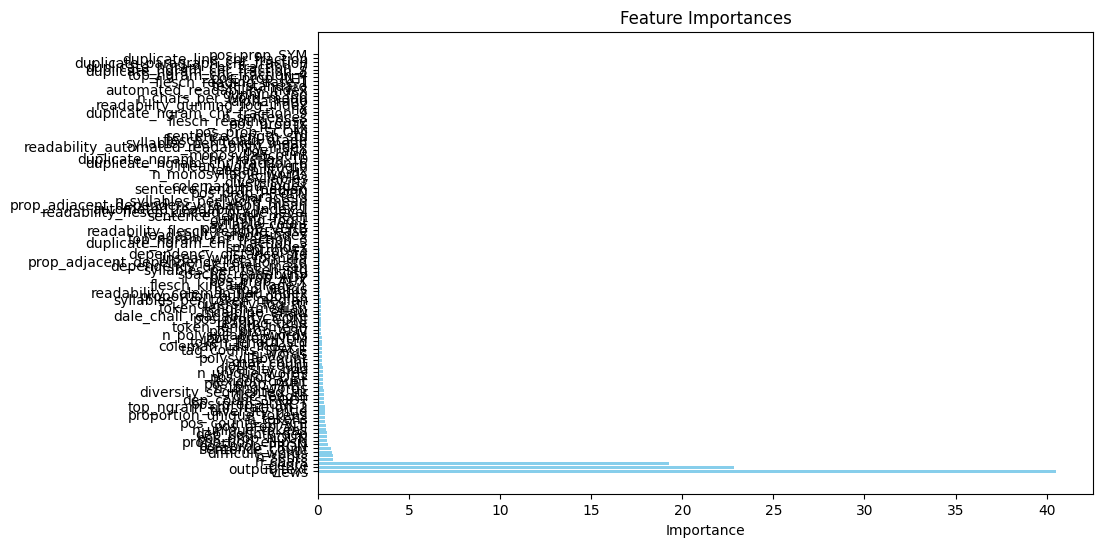

In [ ]:
importances = model.get_feature_importance()

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": importances}
).sort_values(by="Importance", ascending=False)

# Display feature importances
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue"
)
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.show()

In [ ]:
y_pred[-20:]

array([-0.3848382 ,  3.47578809, 66.76403764,  3.33553392,  0.31257395,
       22.09144534,  8.43868561,  4.41495301, 35.29768215,  0.99664661,
        8.28171855,  1.2709696 ,  3.79476562,  7.29183643,  1.76548237,
       14.20064152,  3.3535678 ,  0.94031716, 76.93090629,  6.73740289])

In [ ]:
y_val.to_numpy()[-20:]

array([ 0,  8, 85,  7,  0,  0,  0,  0,  7,  7, 40,  0,  1,  0,  0, 24,  0,
       18, 77,  7])

In [ ]:
model

In [ ]:
pd.concat([y_val, y_pred])

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid